# 이미지를 훈련, 검증, 테스트 디렉터리로 복사하기

In [1]:
import os, shutil, pathlib

original_dir = pathlib.Path('dogs-vs-cats/train')
new_base_dir = pathlib.Path('dogs-vs-cats/cats_vs_dogs_small')
def make_subset(subset_name, start_index, end_index):
    for category in('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f'{category}.{i}.jpg'
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, 
                           dst = dir / fname)
            
make_subset('train', start_index = 0, end_index = 1000)
make_subset('validation', start_index = 1000, end_index = 1500)
make_subset('test', start_index = 1500, end_index = 2500)

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'dogs-vs-cats\\cats_vs_dogs_small\\train\\cat'

# 모델 만들기

## 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs  = keras.Input(shape = (180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation  = 'relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

## 모델 훈련 설정하기

In [4]:
model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

# 데이터 전처리

## image_dataset_from_directory를 사용하여 이미지 읽기

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size = (180, 180),
    batch_size = 32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size = (180, 180),
    batch_size = 32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size = (180, 180),
    batch_size = 32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Dataset이 반환하는 데이터와 레이블 크기 확인하기

In [6]:
for data_batch, labels_batch in train_dataset:
    print('데이터 배치 크기 :', data_batch.shape)
    print('레이블 배치 크기 :', labels_batch.shape)
    break

데이터 배치 크기 : (32, 180, 180, 3)
레이블 배치 크기 : (32,)


# 데이터 훈련

## Dataset을 사용하여 모델 훈련하기

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'dogs-vs-cats/convert_from_scratch.keras',
        save_best_only = True,
        monitor = 'val_loss')
]
history = model.fit(
    train_dataset,
    epochs = 30, 
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 64s 1s/step - loss: 0.7024 - accuracy: 0.4925 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 63s 1s/step - loss: 0.6990 - accuracy: 0.5390 - val_loss: 0.7886 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 68s 1s/step - loss: 0.6825 - accuracy: 0.5780 - val_loss: 0.6466 - val_accuracy: 0.6490
Epoch 4/30
63/63 [==============================] - 65s 1s/step - loss: 0.6213 - accuracy: 0.6525 - val_loss: 0.6294 - val_accuracy: 0.6690
Epoch 5/30
63/63 [==============================] - 60s 959ms/step - loss: 0.6042 - accuracy: 0.6635 - val_loss: 0.6571 - val_accuracy: 0.6110
Epoch 6/30
63/63 [==============================] - 60s 945ms/step - loss: 0.5740 - accuracy: 0.6965 - val_loss: 0.5751 - val_accuracy: 0.6940
Epoch 7/30
63/63 [==============================] - 62s 990ms/step - loss: 0.5688 - accuracy: 0.6975 - val_loss: 0.5756 - val_accuracy: 0.7040
Epoch 8/30


## 훈련 과정의 정확도와 손실 그래프 그리기

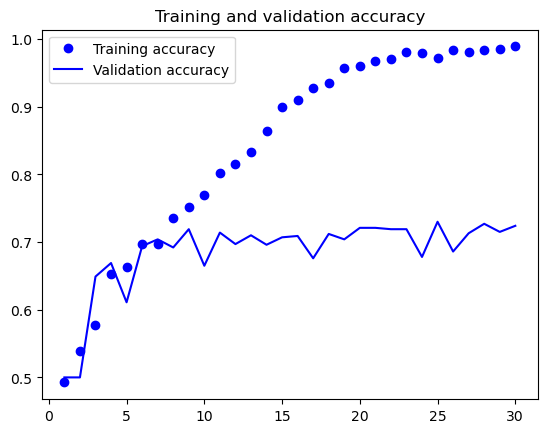

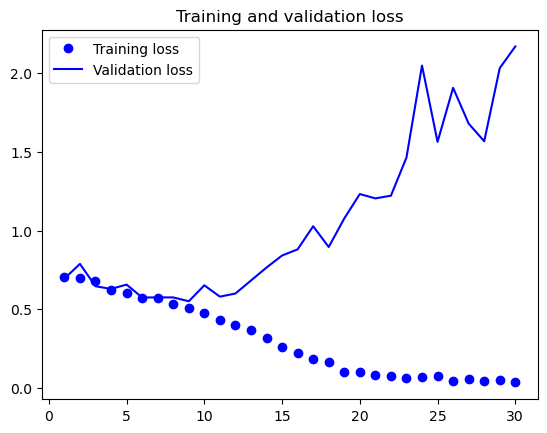

In [8]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 테스트 세트에서 모델 평가하기

In [14]:
test_model = keras.models.load_model('dogs-vs-cats/convert_from_scratch.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 12s 191ms/step - loss: 0.5851 - accuracy: 0.6985
테스트 정확도 : 0.698


# 데이터 증식 사용하기

## 컨브넷에 추가할 데이터 증식 단계 정의하기

In [16]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

## 랜덤하게 증식된 훈련 이미지 출력하기

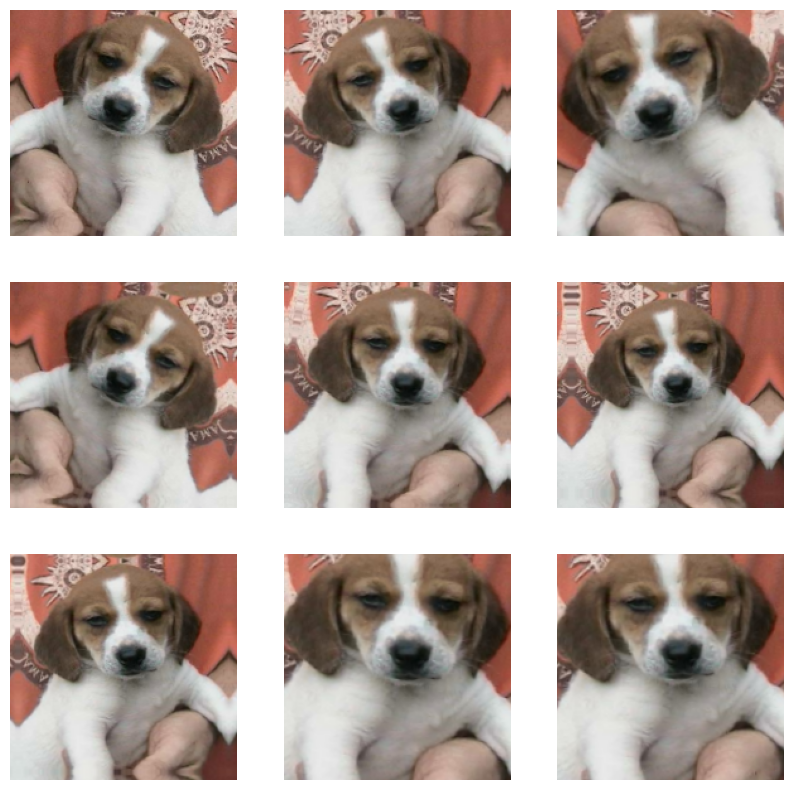

In [21]:
plt.figure(figsize = (10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

## 이미지 증식과 드롭아웃을 포함한 컨브넷 만들기

In [22]:
inputs  = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation  = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation  = 'relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

## 규제를 추가한 컨브넷 훈련하기

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'dogs-vs-cats/convert_from_scratch_with_augmentation.keras',
        save_best_only = True,
        monitor = 'val_loss')
]
history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/100
16/63 [======>.......................] - ETA: 33s - loss: 0.7157 - accuracy: 0.4688

KeyboardInterrupt: 

## 훈련 과정의 정확도와 손실 그래프 그리기

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 테스트 세트에서 모델 훈련하기

In [ ]:
test_model = keras.models.load_model(
    'dogs-vs-cats/convert_from_scratch_with_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')